In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
import heapq
import datetime
import glob
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#BASE_PATH = '/content/gdrive/My Drive/dataa/UCF101_numpy_files'
#VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.npy')
#FILE_SELECTOR = "**/*.npy"
#SEQUENCE_LENGTH = 40

In [ ]:
BASE_PATH = '/content/drive/MyDrive/PhD_dataset/UCF50'
VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.avi')
FILE_SELECTOR = "**/*.avi"
SEQUENCE_LENGTH = 40

In [ ]:
print(VIDEOS_PATH)

/content/drive/MyDrive/PhD_dataset/UCF50/**/*.avi


# Step 1 - Visualize Data

### Plot distribution

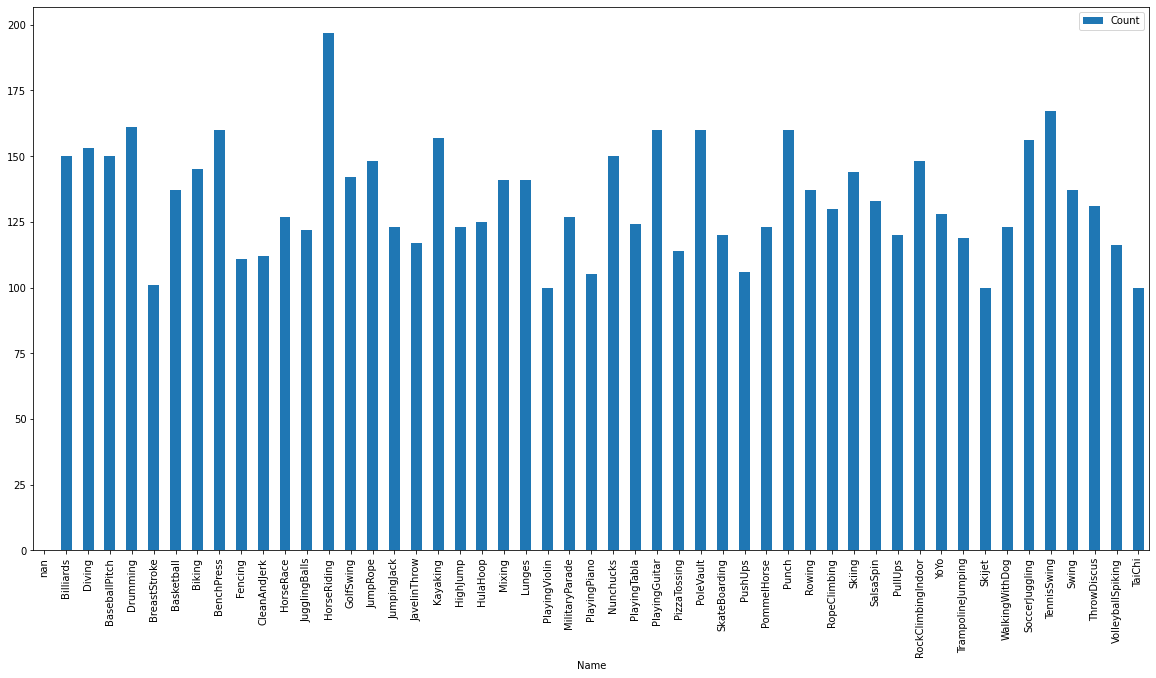

In [ ]:
files = [f for f in glob.glob(BASE_PATH + '/' + FILE_SELECTOR, recursive=True)]
df = pd.DataFrame(columns=['Name', 'Count'], index=['Name'])
for f in files:
    directory = os.path.dirname(f).split(os.sep)[6]
    index = df.index[df['Name'] == directory].tolist()
    if len(index) == 0:
        df = df.append({'Name': directory, 'Count': 0}, ignore_index=True)

    df.loc[df['Name'] == directory, 'Count'] = df.loc[df['Name'] == directory, 'Count'] + 1

df.plot.bar(x='Name', y='Count', rot=90, figsize=(20,10))

In [ ]:
df.tail()

,Name,Count
46,TennisSwing,167
47,Swing,137
48,ThrowDiscus,131
49,VolleyballSpiking,116
50,TaiChi,100


In [ ]:
df.head()

,Name,Count
0,NaN,NaN
1,Billiards,150
2,Diving,153
3,BaseballPitch,150
4,Drumming,161


# Step 2 - Prepare Data

### Train/Validation split

In [ ]:
def read_classes(directory, selector='**/*.avi'):
    files = [f for f in glob.glob(directory + '/'+ selector, recursive=True)]
    df = pd.DataFrame(columns=['classes', 'classids', 'filepaths'])

    # Append all files
    for f in files:
        classname = os.path.dirname(f).split(os.sep)[6]
        filepath = f.replace('\\', '/').replace(BASE_PATH, '')[1:]
        df = df.append({'classes': classname, 'classids': '', 'filepaths': filepath}, ignore_index=True)

    # Add class ids
    classes = df.classes.unique()
    for idx in range(len(classes)):
        classname = classes[idx]
        df.loc[(df['classes'] == classname),'classids'] = idx + 1

    return df

df_classes = read_classes(BASE_PATH)

In [ ]:
df_classes.head()

,classes,classids,filepaths
0,Billiards,1,Billiards/v_Billards_g01_c01.avi
1,Billiards,1,Billiards/v_Billards_g01_c02.avi
2,Billiards,1,Billiards/v_Billards_g01_c03.avi
3,Billiards,1,Billiards/v_Billards_g01_c04.avi
4,Billiards,1,Billiards/v_Billards_g01_c05.avi


In [ ]:
classes = df_classes.classes.unique()
print('Classes: {}'.format(len(classes)))
print(classes)

Classes: 50
['Billiards' 'Diving' 'BaseballPitch' 'Drumming' 'BreastStroke'
 'Basketball' 'Biking' 'BenchPress' 'Fencing' 'CleanAndJerk' 'HorseRace'
 'JugglingBalls' 'HorseRiding' 'GolfSwing' 'JumpRope' 'JumpingJack'
 'JavelinThrow' 'Kayaking' 'HighJump' 'HulaHoop' 'Mixing' 'Lunges'
 'PlayingViolin' 'MilitaryParade' 'PlayingPiano' 'Nunchucks'
 'PlayingTabla' 'PlayingGuitar' 'PizzaTossing' 'PoleVault' 'SkateBoarding'
 'PushUps' 'PommelHorse' 'Punch' 'Rowing' 'RopeClimbing' 'Skiing'
 'SalsaSpin' 'PullUps' 'RockClimbingIndoor' 'YoYo' 'TrampolineJumping'
 'Skijet' 'WalkingWithDog' 'SoccerJuggling' 'TennisSwing' 'Swing'
 'ThrowDiscus' 'VolleyballSpiking' 'TaiChi']


In [ ]:
df_classes.head()

,classes,classids,filepaths
0,Billiards,1,Billiards/v_Billards_g01_c01.avi
1,Billiards,1,Billiards/v_Billards_g01_c02.avi
2,Billiards,1,Billiards/v_Billards_g01_c03.avi
3,Billiards,1,Billiards/v_Billards_g01_c04.avi
4,Billiards,1,Billiards/v_Billards_g01_c05.avi


In [ ]:
df_classes.tail()

,classes,classids,filepaths
6676,TaiChi,50,TaiChi/v_TaiChi_g24_c04.avi
6677,TaiChi,50,TaiChi/v_TaiChi_g25_c01.avi
6678,TaiChi,50,TaiChi/v_TaiChi_g25_c02.avi
6679,TaiChi,50,TaiChi/v_TaiChi_g25_c03.avi
6680,TaiChi,50,TaiChi/v_TaiChi_g25_c04.avi


In [ ]:
!mkdir mk_11

In [ ]:
#trainfile = open('mk_11/trainset.txt', 'w')
#testfile = open('mk_11/testset.txt', 'w')
#validfile = open('mk_11/validset.txt', 'w')
#for idx in range(len(classes)):
#    class_subset = df_classes[df_classes['classes'] == classes[idx]]
#    train, valid = train_test_split(class_subset, test_size=0.2)
#    train, test = train_test_split(train, test_size=0.2)
#
#    for index, row in train.iterrows():
#        trainfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')
#
#    for index, row in valid.iterrows():
#        validfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')
#
#    for index, row in test.iterrows():
#        testfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')
#
#trainfile.close()
#testfile.close()
#validfile.close()

# Step 3 - Extract features from videos and cache them in files

### Sample 'SEQUENCE_LENGTH' frames from each video

In [ ]:
def frame_generator():
    video_paths = tf.io.gfile.glob(VIDEOS_PATH)
    #print('video_paths')
    np.random.shuffle(video_paths)
    #print('video_paths')
    for video_path in video_paths:
        frames = []
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0

        label = os.path.basename(os.path.dirname(video_path))

        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (224, 224))
                img = tf.keras.applications.densenet.preprocess_input(
                    img)
                max_images -= 1
                yield img, video_path

            if max_images == 0:
                break
            current_frame += 1

dataset = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((224, 224, 3), ()))

dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
"""current_frame=6
sample_every_frame=3
print(current_frame%sample_every_frame)"""

'current_frame=6\nsample_every_frame=3\nprint(current_frame%sample_every_frame)'

In [ ]:
video_paths = tf.io.gfile.glob(VIDEOS_PATH)
#cap = cv2.VideoCapture(video_path)

In [ ]:
print(video_paths)

['/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c01.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c02.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c03.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c04.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c05.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g01_c06.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c01.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c02.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c03.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c04.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c05.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c06.avi', '/content/drive/MyDrive/PhD_dataset/UCF50/Billiards/v_Billards_g02_c07.avi'

In [ ]:
#video_path="/content/drive/MyDrive/PhD_dataset/UCF-101/Basketball/v_Basketball_g01_c01.avi"

In [ ]:
#cap = cv2.VideoCapture(video_path)

In [ ]:
#print(cap)

In [ ]:
#sucesss,frame = cap.read()

In [ ]:
#frame

In [ ]:
#img = tf.image.resize(frame, (224, 224))

In [ ]:
#img

In [ ]:
#frame.shape

In [ ]:
old_folder = 'UCF50'
model = 'densenet_50'
new_folder = old_folder +'_'+ model

f =[x[0].replace(old_folder,new_folder) for x in os.walk(BASE_PATH)]

for path in f:
  if not os.path.isdir(path):
    os.mkdir(path)

#### Extract Features from videos

In [ ]:
 densenet = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet')
 x = densenet.output
 # We add Average Pooling to transform the feature map from
 # 8 * 8 * 2048 to 1 x 2048, as we don't need spatial information
 pooling_output = tf.keras.layers.GlobalMaxPooling2D()(x)
 #pooling_output = tf.keras.layer.GlobalMaxPooling2D()(x)
 #pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)
 feature_extraction_model = tf.keras.Model(densenet.input, pooling_output)
 feature_extraction_model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________

In [ ]:
 current_path = None
 all_features = []

 for img, batch_paths in tqdm.tqdm(dataset):
     batch_features = feature_extraction_model(img)
     batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))

     for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
         if path != current_path and current_path is not None:
             output_path = current_path.decode().replace('.avi', '.npy')
             output_path = output_path.replace(old_folder, new_folder)
             np.save(output_path, all_features)
             all_features = []

         current_path = path
         all_features.append(features)

711it [08:41,  1.36it/s]


OSError: ignored

In [ ]:
abc =np.load("//content/drive/MyDrive/PhD_dataset/UCF50_densenet_50/Basketball/v_Basketball_g01_c02.npy")

In [ ]:
abc.shape

In [ ]:
BASE_PATH = '/content/drive/MyDrive/PhD_dataset/UCF50_densenet_50'
VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.npy')
FILE_SELECTOR = "**/*.npy"
SEQUENCE_LENGTH = 40

In [ ]:
files = [f for f in glob.glob(BASE_PATH + '/' + FILE_SELECTOR, recursive=True)]
df = pd.DataFrame(columns=['Name', 'Count'], index=['Name'])
for f in files:
    directory = os.path.dirname(f).split(os.sep)[6]
    index = df.index[df['Name'] == directory].tolist()
    if len(index) == 0:
        df = df.append({'Name': directory, 'Count': 0}, ignore_index=True)

    df.loc[df['Name'] == directory, 'Count'] = df.loc[df['Name'] == directory, 'Count'] + 1

df.plot.bar(x='Name', y='Count', rot=90, figsize=(20,10))

In [ ]:
def read_classes(directory, selector='**/*.npy'):
    files = [f for f in glob.glob(directory + '/'+ selector, recursive=True)]
    df = pd.DataFrame(columns=['classes', 'classids', 'filepaths'])

    # Append all files
    for f in files:
        classname = os.path.dirname(f).split(os.sep)[6]
        filepath = f.replace('\\', '/').replace(BASE_PATH, '')[1:]
        df = df.append({'classes': classname, 'classids': '', 'filepaths': filepath}, ignore_index=True)

    # Add class ids
    classes = df.classes.unique()
    for idx in range(len(classes)):
        classname = classes[idx]
        df.loc[(df['classes'] == classname),'classids'] = idx + 1

    return df

df_classes = read_classes(BASE_PATH)

In [ ]:
classes = df_classes.classes.unique()
print('Classes: {}'.format(len(classes)))
print(classes)

In [ ]:
!mkdir mk_11

In [ ]:
trainfile = open('mk_11/trainset.txt', 'w')
testfile = open('mk_11/testset.txt', 'w')
validfile = open('mk_11/validset.txt', 'w')
for idx in range(len(classes)):
    class_subset = df_classes[df_classes['classes'] == classes[idx]]
    train, valid = train_test_split(class_subset, test_size=0.2)
    train, test = train_test_split(train, test_size=0.2)

    for index, row in train.iterrows():
        trainfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')

    for index, row in valid.iterrows():
        validfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')

    for index, row in test.iterrows():
        testfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')

trainfile.close()
testfile.close()
validfile.close()

# Step 2: Train the LSTM on video features

#### Labels preprocessing

In [ ]:
LABELS = classes
encoder = LabelBinarizer()
encoder.fit(LABELS)
print('Classes: {}'.format(len(encoder.classes_)))

In [ ]:
encoder.classes_

#### Defining the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.),
    tf.keras.layers.LSTM(516, dropout=0.5, return_sequences=True, recurrent_dropout=0.5),
    tf.keras.layers.LSTM(516, dropout=0.5, return_sequences=True,recurrent_dropout=0.5),
    tf.keras.layers.LSTM(516 ),
    tf.keras.layers.Dense(516, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
with open('mk_11/trainset.txt') as f:
    train_list = [row.strip() for row in list(f)]
    train_list = [row.split(' ')[0] for row in train_list if len(row.split(' '))==2]

with open('mk_11/validset.txt') as f:
    valid_list = [row.strip() for row in list(f)]
    valid_list = [row.split(' ')[0] for row in valid_list if len(row.split(' '))==2]

def make_generator(file_list):
    def generator():
        np.random.shuffle(file_list)
        for path in file_list:
            full_path = os.path.join(BASE_PATH, path)

            label = os.path.basename(os.path.dirname(path))
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 1920))
            #padded_sequence = np.zeros((SEQUENCE_LENGTH, 17280))
            padded_sequence[0:len(features)] = np.array(features)

            transformed_label = encoder.transform([label])
            yield padded_sequence, transformed_label[0]
    return generator

In [ ]:
train_dataset = tf.data.Dataset.from_generator(make_generator(train_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 1920), (len(LABELS))))
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(make_generator(valid_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 1920), (len(LABELS))))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint("mk_11/model_new.h5", verbose=1, save_best_only=True)

earlystopping = EarlyStopping(patience=10, verbose=1)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_dataset, epochs=100, callbacks=[tensorboard_callback, checkpoint, earlystopping], validation_data=valid_dataset)

In [ ]:
!cp -r mk_11/model_new.h5 /content/drive/MyDrive

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
tuner = kt.RandomSearch(
    model,
    objective='val_loss',
    max_trials=5)


# Step 3: Predict on Video

In [ ]:
with open('/content/mk_11/testset.txt') as f:
    test_list = [row.strip() for row in list(f)]
    test_list = [row.split(' ')[0] for row in test_list if len(row.split(' '))==2]

def make_generator(file_list):
    def generator():
        # np.random.shuffle(file_list)
        for path in file_list:
            full_path = os.path.join(BASE_PATH, path)

            label = os.path.basename(os.path.dirname(path))
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 1920))
            padded_sequence[0:len(features)] = np.array(features)

            transformed_label = encoder.transform([label])
            yield padded_sequence, transformed_label[0]
    return generator

In [ ]:
test_dataset = tf.data.Dataset.from_generator(make_generator(test_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 1920), (len(LABELS))))
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#from keras.models import load_model
#model = load_model('/content/mk_11/model_new.h5')

In [ ]:
test_loss,test_acc,topk_test_acc = model.evaluate(test_dataset)

In [ ]:
print(f' Test accuracy : {test_acc} \n Top-k test_accuracy : {topk_test_acc}')

In [ ]:
pred = model.predict(test_dataset)
arg_y_pred = pred.argmax(axis=-1)

In [ ]:
y_pred = np.zeros((len(arg_y_pred),len(LABELS)))
y_pred[np.arange(arg_y_pred.size),arg_y_pred] = 1
y_pred.shape

In [ ]:
y_true = list()
for x in test_list:
  y_true.append(encoder.transform([x.split("/")[0]])[0])
y_true = np.array(y_true)
y_true.shape

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))